# **TF-IDF + LogisticRegression**

# Module 1: Tiền xử lý tổng quát

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# 1. Cài đặt thư viện cần thiết
!pip install underthesea rouge-score scikit-learn pandas networkx matplotlib seaborn

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from underthesea import word_tokenize
from rouge_score import rouge_scorer

# 2. Hàm làm sạch văn bản
def clean_text(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'<[^>]+>', '', text)  # Xóa HTML
    text = re.sub(r'http\S+', '', text)  # Xóa URL
    text = re.sub(r'\s+', ' ', text).strip() # Chuẩn hóa khoảng trắng
    return text

# 3. Hàm tách từ
def segment_text(text):
    try:
        return word_tokenize(text, format="text")
    except:
        return text

# 4. Chuẩn bị dữ liệu
df = pd.read_csv("/content/drive/MyDrive/NLP_PROJECT/data/csv_file/original_summary.csv")

print("Đang xử lý dữ liệu...")
df['clean_content'] = df['content'].apply(clean_text)
df['clean_summary'] = df['summary'].apply(clean_text)

df['segmented_content'] = df['clean_content'].apply(segment_text)
df['segmented_summary'] = df['clean_summary'].apply(segment_text)

print(f"Đã tải {len(df)} mẫu dữ liệu.")
df.head(2)

Đang xử lý dữ liệu...
Đã tải 100 mẫu dữ liệu.


,title,content,summary,clean_content,clean_summary,segmented_content,segmented_summary
0,Làng gốm Thanh Hà giành giải 'Điểm du lịch cộn...,"Sáng 27/9, làng gốm Thanh Hà (phường Thanh Hà,...","Làng gốm Thanh Hà được vinh danh là ""Điểm du l...","Sáng 27/9, làng gốm Thanh Hà (phường Thanh Hà,...","Làng gốm Thanh Hà được vinh danh là ""Điểm du l...","Sáng 27/9 , làng gốm_Thanh_Hà ( phường Thanh_H...","Làng gốm Thanh_Hà được vinh_danh là "" Điểm du_..."
1,"""Đọc bã"" cà phê đoán vận mệnh ở Thổ Nhĩ Kỳ","Ở Thổ Nhĩ Kỳ, cà phê đi kèm một chút định mệnh...","Ở Thổ Nhĩ Kỳ, khi uống cạn cà phê, người dân t...","Ở Thổ Nhĩ Kỳ, cà phê đi kèm một chút định mệnh...","Ở Thổ Nhĩ Kỳ, khi uống cạn cà phê, người dân t...","Ở Thổ_Nhĩ_Kỳ , cà_phê đi kèm một_chút định_mện...","Ở Thổ_Nhĩ_Kỳ , khi uống cạn cà_phê , người_dân..."


# Module 2: Mô hình chính

In [26]:
# Cài đặt thư viện cần thiết
from sklearn.feature_extraction.text import TfidfVectorizer
from underthesea import sent_tokenize, word_tokenize
from rouge_score import rouge_scorer
import numpy as np
import os
import textwrap

In [27]:
# Xây dựng LR
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.1, n_iters=1000, class_weight=None, random_state=None):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.class_weight = class_weight
        if random_state:
            np.random.seed(random_state)

    # Hàm Sigmoid: Chuyển đổi giá trị tuyến tính sang xác suất (0-1)
    def _sigmoid(self, z):
        # Dùng clip để tránh lỗi tràn số (overflow) khi mũ e quá lớn
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Xử lý Class Weight
        sample_weights = np.ones(n_samples)
        if self.class_weight == 'balanced':
            n_class_0 = np.sum(y == 0)
            n_class_1 = np.sum(y == 1)
            # Công thức chuẩn của sklearn: n_samples / (n_classes * np.bincount(y))
            if n_class_1 > 0 and n_class_0 > 0:
                w0 = n_samples / (2 * n_class_0)
                w1 = n_samples / (2 * n_class_1)
                sample_weights = np.where(y == 1, w1, w0)


        for _ in range(self.n_iters):
            # 1. Dự đoán tuyến tính: y = wx + b
            linear_model = np.dot(X, self.weights) + self.bias

            # 2. Hàm kích hoạt
            y_predicted = self._sigmoid(linear_model)

            # 3. Tính đạo hàm (Gradient) có trọng số
            # Lỗi dự đoán
            error = (y_predicted - y) * sample_weights

            dw = (1 / n_samples) * np.dot(X.T, error)
            db = (1 / n_samples) * np.sum(error)

            # 4. Cập nhật tham số
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    # Hàm dự đoán xác suất (để khớp với logic cũ lấy top câu)
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        # Trả về mảng 2 cột: [xác suất là 0, xác suất là 1]
        return np.column_stack((1 - y_predicted, y_predicted))


In [28]:
# Chia tập train/test
train_size = 80
df_train = df.iloc[:train_size].copy()
df_test = df.iloc[train_size:].copy()

In [29]:
# Tách văn bản thành các câu và từ
def get_segmented_sentences(text):
    if not isinstance(text, str) or not text.strip(): return [], []
    sents = sent_tokenize(text)
    valid_sents = []
    valid_seg = []
    for s in sents:
        try:
            seg = word_tokenize(s, format="text")
            # Lọc câu quá ngắn (rác)
            if len(seg.split()) >= 5:
                valid_sents.append(s)
                valid_seg.append(seg)
        except: continue
    return valid_sents, valid_seg

# Gán nhãn (Labeling) dùng ROUGE
def generate_labels_dynamic(original_sents_seg, summary_text, top_n=3):
    if not summary_text or not original_sents_seg:
        return [0] * len(original_sents_seg)

    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=False)
    summary_seg = word_tokenize(str(summary_text), format="text")

    scores = []
    for sent in original_sents_seg:
        try:
            s = scorer.score(summary_seg, sent)['rouge1'].fmeasure
            scores.append(s)
        except:
            scores.append(0.0)

    scores_np = np.array(scores)

    # Chọn top câu có điểm ROUGE cao nhất làm nhãn 1
    actual_top_n = min(top_n, len(scores))
    top_indices = scores_np.argsort()[-actual_top_n:][::-1]

    labels = [0] * len(original_sents_seg)
    for idx in top_indices:
        if scores[idx] > 0.1: # Ngưỡng tối thiểu
            labels[idx] = 1

    return labels


In [ ]:
all_train_sents_seg = []
for content in df_train['clean_content']:
    _, seg_sents = get_segmented_sentences(content)
    all_train_sents_seg.extend(seg_sents)

# Khởi tạo TF-IDF Vectorizer
if len(all_train_sents_seg) > 0:
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2)
    vectorizer.fit(all_train_sents_seg)
else:
    print("Cảnh báo: Không đủ dữ liệu để train vectorizer")

def extract_features(seg_sentences, vectorizer):
    if not seg_sentences: return None
    # Lấy đặc trưng từ ngữ nghĩa
    tfidf_mat = vectorizer.transform(seg_sentences).toarray()

    # Lấy đặc trưng vị trí và độ dài
    n_sents = len(seg_sentences)
    positions = np.array([i/n_sents for i in range(n_sents)]).reshape(-1, 1)
    lengths = np.array([min(len(s.split())/100, 1.0) for s in seg_sentences]).reshape(-1, 1)

    # Ghép lại thành ma trận đặc trưng tổng hợp
    return np.hstack([tfidf_mat, positions, lengths])


X_train, y_train = [], []

for _, row in df_train.iterrows():
    _, seg_sents = get_segmented_sentences(row['clean_content'])
    if not seg_sents: continue

    feats = extract_features(seg_sents, vectorizer)
    labs = generate_labels_dynamic(seg_sents, row['clean_summary'], top_n=3)

    if len(feats) == len(labs):
        X_train.extend(feats)
        y_train.extend(labs)

X_train = np.array(X_train)
y_train = np.array(y_train)


In [15]:
# Learning rate = 0.5
# n_iters = 1500 để đảm bảo hội tụ
model = CustomLogisticRegression(learning_rate=0.5, n_iters=1500, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

print(f"Huấn luyện xong. Số mẫu: {len(y_train)}. Tỷ lệ Positive: {sum(y_train)/len(y_train) if len(y_train) > 0 else 0:.2%}")

Huấn luyện xong. Số mẫu: 2230. Tỷ lệ Positive: 10.76%


In [16]:
def lr_predict(text, top_k=3):
    raw_sents, seg_sents = get_segmented_sentences(text)
    if not seg_sents: return ""
    if len(raw_sents) <= top_k: return text

    features = extract_features(seg_sents, vectorizer)

    # Dùng hàm predict_proba của custom model
    # Lấy cột index 1 (xác suất là nhãn 1)
    probs = model.predict_proba(features)[:, 1]

    top_indices = probs.argsort()[-top_k:][::-1]
    top_indices.sort()
    return " ".join([raw_sents[i] for i in top_indices])

df['predicted_summary'] = df['clean_content'].apply(lambda x: lr_predict(x, top_k=3))

output_path = "/content/drive/MyDrive/NLP_PROJECT/Model/TFIDF_Logistic_results/Result_TFIDF_Custom_Logistic.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df[['clean_content', 'clean_summary', 'predicted_summary']].to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"Đã lưu file kết quả tại: {output_path}")

# In thử 1 mẫu
sample = df.sample(1).iloc[0]
print("\n KẾT QUẢ MẪU")
print("GỐC:", textwrap.fill(str(sample['clean_content'])[:150] + "...", width=80))
print("-" * 20)
print("MÁY DỰ ĐOÁN:", textwrap.fill(str(sample['predicted_summary']), width=80))

Đã lưu file kết quả tại: /content/drive/MyDrive/NLP_PROJECT/Model/TFIDF_Logistic_results/Result_TFIDF_Custom_Logistic.csv

 KẾT QUẢ MẪU
GỐC: Các bức tượng hình cánh tay tại khu du lịch Hải Tiến bị sóng đánh lật nghiêng
sau bão Kajiki, tiềm ẩn nguy cơ gây tai nạn cho người dân và du khách tắ...
--------------------
MÁY DỰ ĐOÁN: Các bức tượng bật đế, trồi ra nhiều thanh sắt gia cố phía dưới nền cát, tạo ra
bẫy hàm ếch, tiềm ẩn nguy cơ tai nạn nếu người dân, du khách đến gần khi tắm
biển hoặc leo lên chụp ảnh. Tượng 5 cánh tay khổng lồ là một hạng mục trong dự
án sửa chữa, chỉnh trang tuyến đường ven biển khu du lịch Hải Tiến với tổng mức
đầu tư khoảng 10 tỷ đồng của UBND huyện Hoằng Hóa cũ vào tháng 3/2023. Sau khi
hoàn thành, nhiều người dân và du khách cho rằng công trình thô kệch, phá vỡ
cảnh quan tự nhiên và chắn mất không gian bờ biển vốn đã bị thu hẹp do thủy
triều xâm thực những năm gần đây.


# Module 3: Đánh giá & vẽ biểu đồ

In [17]:
#  Cài đặt thư viện cần thiết
from rouge_score import rouge_scorer
from underthesea import word_tokenize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive

In [18]:
# Thiết lập các biến và tải dữ liệu kết quả từ file CSV hoặc sử dụng DataFrame hiện có
RESULT_FILE_PATH = "/content/drive/MyDrive/NLP_PROJECT/Model/TFIDF_Logistic_results/Result_TFIDF_Logistic.csv"
MODEL_NAME = "TFIDF & LogisticRegression"
col_gen = "predicted_summary"
col_ref = "clean_summary"
col_src = "clean_content"

if not os.path.exists('/content/drive'): drive.mount('/content/drive')

if os.path.exists(RESULT_FILE_PATH):
    df = pd.read_csv(RESULT_FILE_PATH).dropna(subset=[col_gen, col_ref])
else:
    try:
        df = df.copy()
    except NameError:
        raise FileNotFoundError("Không tìm thấy dữ liệu (File CSV hoặc biến df).")

In [19]:
# Định nghĩa hàm đánh giá ROUGE cho tiếng Việt và tính toán các chỉ số ROUGE
def evaluate_rouge_vietnamese(preds, refs):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for pred, ref in zip(preds, refs):
        pred = str(pred) if pd.notna(pred) else ""
        ref = str(ref) if pd.notna(ref) else ""
        pred_seg = word_tokenize(pred, format="text")
        ref_seg = word_tokenize(ref, format="text")

        score = scorer.score(ref_seg, pred_seg)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)

    return {k: np.mean(v) for k, v in scores.items()}

rouge_results = evaluate_rouge_vietnamese(df[col_gen], df[col_ref])
print(f"Kết quả rouge của {MODEL_NAME}: {rouge_results}")

df_current = df.copy()
df_current['gen_len'] = df_current[col_gen].apply(lambda x: len(str(x).split()))
df_current['ref_len'] = df_current[col_ref].apply(lambda x: len(str(x).split()))
df_current['src_len'] = df_current[col_src].apply(lambda x: len(str(x).split()))
df_current['length_group'] = df_current['src_len'].apply(lambda x: "< 300" if x < 300 else ("300-600" if x <= 600 else "> 600"))

ROUGE Results for TFIDF & LogisticRegression: {'rouge1': np.float64(0.6639867449327067), 'rouge2': np.float64(0.3597151761157191), 'rougeL': np.float64(0.3404185304955355)}


/tmp/ipython-input-4142108416.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metrics, y=values, palette="viridis")


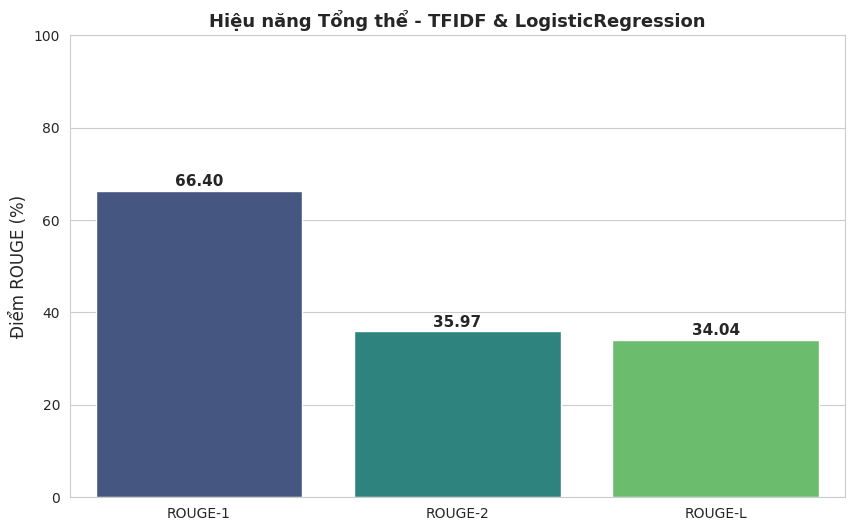

In [20]:
# BIỂU ĐỒ 1: HIỆU NĂNG TỔNG THỂ
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
values = [
    rouge_results['rouge1'] * 100,
    rouge_results['rouge2'] * 100,
    rouge_results['rougeL'] * 100
]

ax = sns.barplot(x=metrics, y=values, palette="viridis")
plt.title(f"Hiệu năng Tổng thể - {MODEL_NAME}", fontsize=13, weight='bold')
plt.ylabel("Điểm ROUGE (%)", fontsize=12)
plt.ylim(0, 100)

for i, v in enumerate(values):
    ax.text(i, v + 1, f"{v:.2f}", ha='center', fontsize=11, fontweight='bold')

plt.show()

/tmp/ipython-input-346215460.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=groups, y=g_scores, palette="magma")


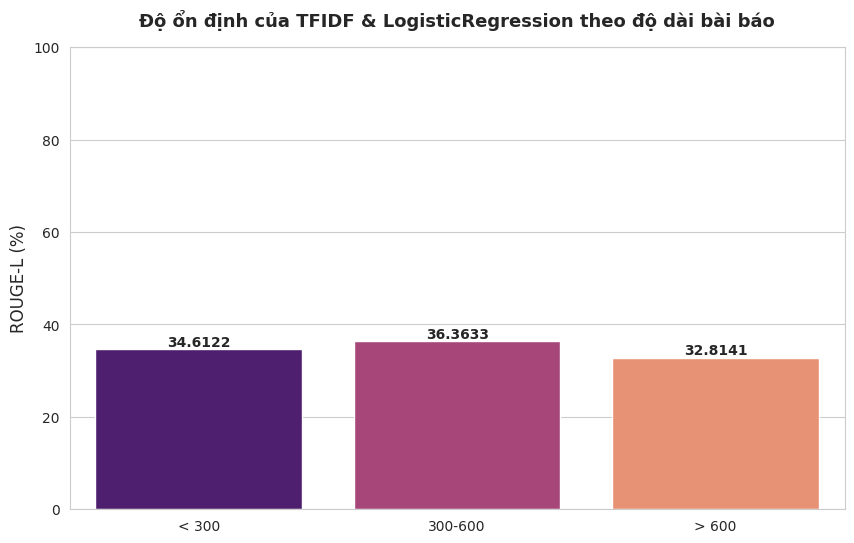

In [21]:
# BIỂU ĐỒ 2: ROUGE THEO ĐỘ DÀI
plt.figure(figsize=(10, 6))
groups = ["< 300", "300-600", "> 600"]
g_scores = []

for g in groups:
    sub = df_current[df_current["length_group"] == g]
    score = evaluate_rouge_vietnamese(sub[col_gen], sub[col_ref])['rougeL'] if len(sub) > 0 else 0
    g_scores.append(score * 100)

sns.barplot(x=groups, y=g_scores, palette="magma")
plt.title(f"Độ ổn định của {MODEL_NAME} theo độ dài bài báo", fontsize=13, weight='bold', pad=15)
plt.ylabel("ROUGE-L (%)", fontsize=12)
plt.xlabel("")
plt.ylim(0, 100)
for i, v in enumerate(g_scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontweight='bold')
plt.show()


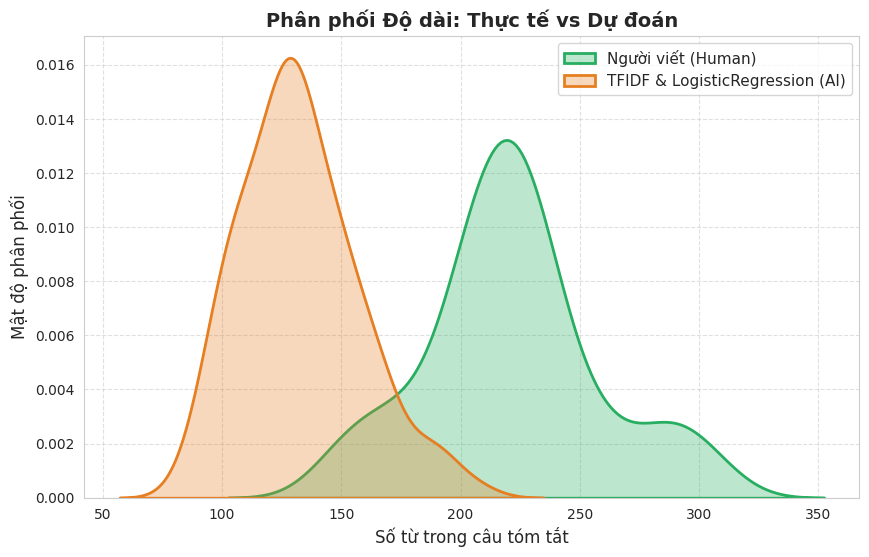

In [22]:
# BIỂU ĐỒ 3: SO SÁNH PHÂN PHỐI ĐỘ DÀI
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=df_current, x="ref_len", fill=True,
    label="Người viết (Human)", color="#27ae60", alpha=0.3, linewidth=2
)

sns.kdeplot(
    data=df_current, x="gen_len", fill=True,
    label=f"{MODEL_NAME} (AI)", color="#e67e22", alpha=0.3, linewidth=2
)

plt.title("Phân phối Độ dài: Thực tế vs Dự đoán", fontsize=14, weight='bold')
plt.xlabel("Số từ trong câu tóm tắt", fontsize=12)
plt.ylabel("Mật độ phân phối", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

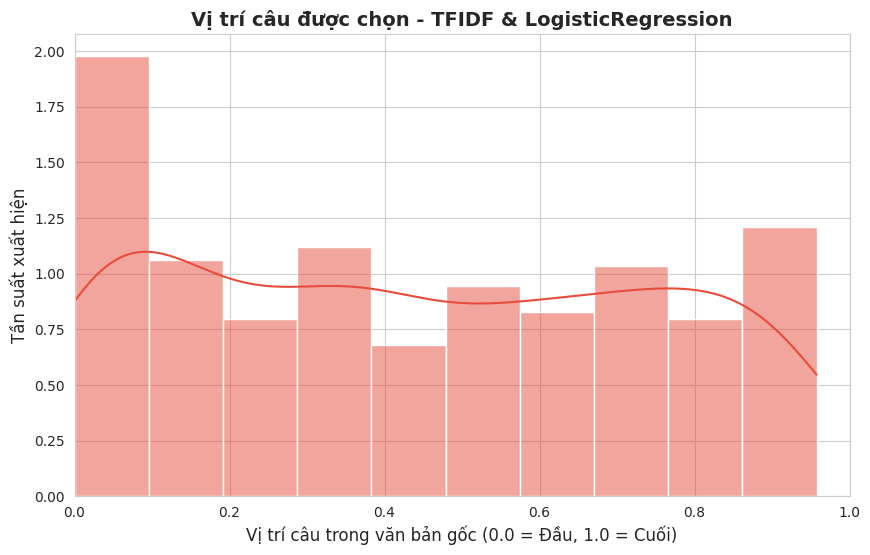

In [23]:
# BIỂU ĐỒ 4: THIÊN KIẾN VỊ TRÍ (LEAD BIAS)
from difflib import SequenceMatcher

def find_best_match_position(generated_text, original_text):
    gen_sents = str(generated_text).split('.')
    org_sents = str(original_text).split('.')
    if len(org_sents) == 0: return []

    positions = []
    for g_sent in gen_sents:
        if len(g_sent) < 10: continue
        best_ratio = 0
        best_idx = 0
        for i, o_sent in enumerate(org_sents):
            ratio = SequenceMatcher(None, g_sent, o_sent).ratio()
            if ratio > best_ratio:
                best_ratio = ratio
                best_idx = i
        if best_ratio > 0.5:
            positions.append(best_idx / len(org_sents))
    return positions

all_positions = []
for idx, row in df_current.iterrows():
    pos = find_best_match_position(row[col_gen], row[col_src])
    all_positions.extend(pos)

plt.figure(figsize=(10, 6))
sns.histplot(all_positions, bins=10, kde=True, color="#e74c3c", stat="density")

plt.title(f"Vị trí câu được chọn - {MODEL_NAME}", fontsize=14, weight='bold')
plt.xlabel("Vị trí câu trong văn bản gốc (0.0 = Đầu, 1.0 = Cuối)", fontsize=12)
plt.ylabel("Tần suất xuất hiện", fontsize=12)
plt.xlim(0, 1)

plt.show()